In [1]:
from fastai2.vision.all import *
from moving_mnist.models.conv_rnn import *
from moving_mnist.data import *

In [2]:
torch.cuda.set_device(0)
torch.cuda.get_device_name()

'Quadro RTX 8000'

# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2,3])

In [4]:
train_tl = TfmdLists(range(5000), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [5]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=32,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

Left: Input, Right: Target

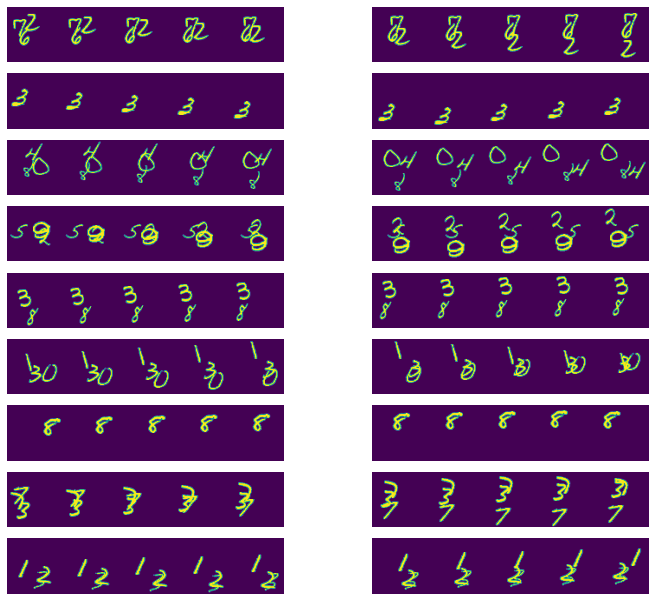

In [6]:
dls.show_batch()

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [7]:
model = StackUnstack(SimpleModel(act=partial(nn.LeakyReLU, 0.05, inplace=True), strategy='encoder'))

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [ ]:
loss_func = StackLoss(MSEL)

In [11]:
learn = Learner(dls, model, loss_func=stack_loss, cbs=[]).to_fp16()

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

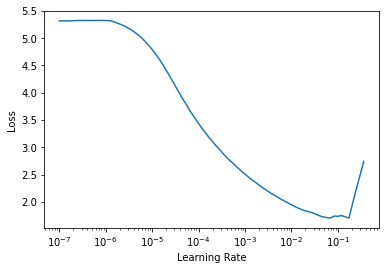

In [28]:
learn.lr_find()

In [12]:
learn.fit_one_cycle(10, 1e-4)

In [13]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [14]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [15]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

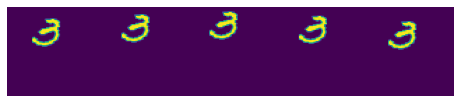

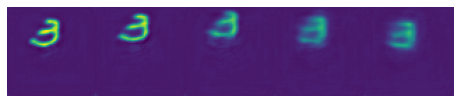

In [24]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)

## A bigger Decoder

We will pass:
- `blur`: to use blur on the upsampling path (this is done by using and a poolling layer and a replication)
- `attn`: to include a self attention layer on the decoder

In [25]:
model2 = StackUnstack(SimpleModel(act=partial(nn.LeakyReLU, 0.05, inplace=True),blur=True, attn=True, strategy='encoder'))

We have to reduce batch size as the self attention layer is heavy.

In [26]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=16,
                             after_batch=[Normalize.from_stats(imagenet_stats[0][0], 
                                                               imagenet_stats[1][0])]).cuda()

In [28]:
learn2 = Learner(dls, model2, loss_func=stack_loss, cbs=[]).to_fp16()

In [17]:
learn2.lr_find()

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=1.737800812406931e-05)

In [29]:
learn2.fit_one_cycle(10, 1e-4)

In [30]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [31]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [32]:
def show_res(t, idx):
    im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

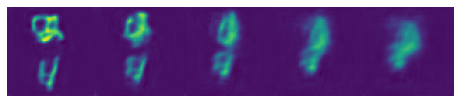

In [39]:
k = random.randint(0,100)
show_res(t,k)
show_res(p,k)